In [4]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [10]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [6]:
def load_and_transform_df(data_file):
    df = pd.read_csv(data_file) 
    df = df.drop(columns= ['Unnamed: 0'])

    mapping_dict = {
    "Центральный федеральный округ": "ЦФО",
    "Приволжский федеральный округ": "ПФО",
    "Дальневосточный федеральный округ": "ДФО",
    "Северо-Западный федеральный округ": "СЗФО",
    "Сибирский федеральный округ": "СФО",
    "Южный федеральный округ": "ЮФО",
    "Северо-Кавказский федеральный округ": "СКФО",
    "Уральский федеральный округ": "УФО"
    }

    df["Округ"] = df["Округ"].map(mapping_dict)

    # столбец добавляется для создания иерархии
    df["Округ_Область"] = df.apply(lambda x: f"{x['Округ']}_{x['Область']}", axis=1)
    
    df['Кол-во'] = df['Кол-во']/1000 #отображение в сотнях тысяч
    
    return df

def create_hierarchy_df(df, is_q=True):  
    # нижний уровень
    df_bottom_level = df.pivot(index="Год", columns="Округ_Область", values="Кол-во")

    #средний уровень
    df_middle_level = df.groupby(["Год", "Округ"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="Год", columns="Округ", values="Кол-во")

    # верхний уровень
    df_total = df.groupby("Год")["Кол-во"] \
             .sum() \
             .to_frame() \
             .rename(columns={"Кол-во": "total"})

    # соединение
    hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
    if is_q:
        hierarchy_df.index = pd.to_datetime(hierarchy_df.index, format="%d.%m.%Y")
        hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()
    else:
        hierarchy_df.index = pd.to_datetime(hierarchy_df.index, format="%Y")
        hierarchy_df = hierarchy_df.resample("YS") \
                           .sum()
    
    hierarchy_df.fillna(0, inplace=True)
    
    return hierarchy_df

def create_hierarchy(df):   
    # создание иерархии
    districts = df["Округ"].unique()
    regions = df["Округ_Область"].unique()

    total = {'total': list(districts)}
    state = {k: [v for v in regions if v.startswith(k)] for k in districts}
    hierarchy = {**total, **state}
    
    return hierarchy

In [7]:
steps_ahead = 1

def plot_results(pred_df, source_df, cols_to_plot, mae):
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        print(f'MAE {col}:', round(mae[col], 2))
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips")

def get_mae(pred_df, source_df, steps_ahead):
    drop_pred = pred_df.drop(pred_df.tail(steps_ahead).index, inplace=False)
    residuals_abs = abs(drop_pred - source_df)
    return residuals_abs.mean()

def experiment(hierarchy_df, hierarchy, steps_ahead, model, approach, levels):
    model = hts.HTSRegressor(model=model, revision_method=approach, n_jobs=0)
    model = model.fit(hierarchy_df, hierarchy)
    pred = model.predict(steps_ahead=steps_ahead)
    mae = get_mae(pred, hierarchy_df, steps_ahead)
    
    for level in levels:
        plot_results(pred, hierarchy_df, level, mae)

# Эксперименты с данными по годам

In [8]:
df_y = load_and_transform_df('data_y.csv')
hierarchy_df_y = create_hierarchy_df(df_y, is_q=False)
hierarchy = create_hierarchy(df_y)

<AxesSubplot:title={'center':'total level'}, xlabel='Год'>

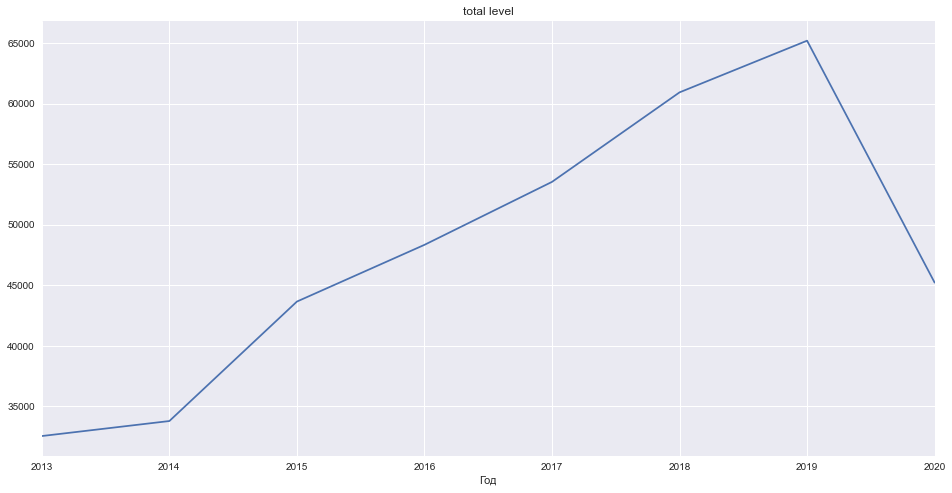

In [5]:
hierarchy_df_y["total"].plot(title="total level")

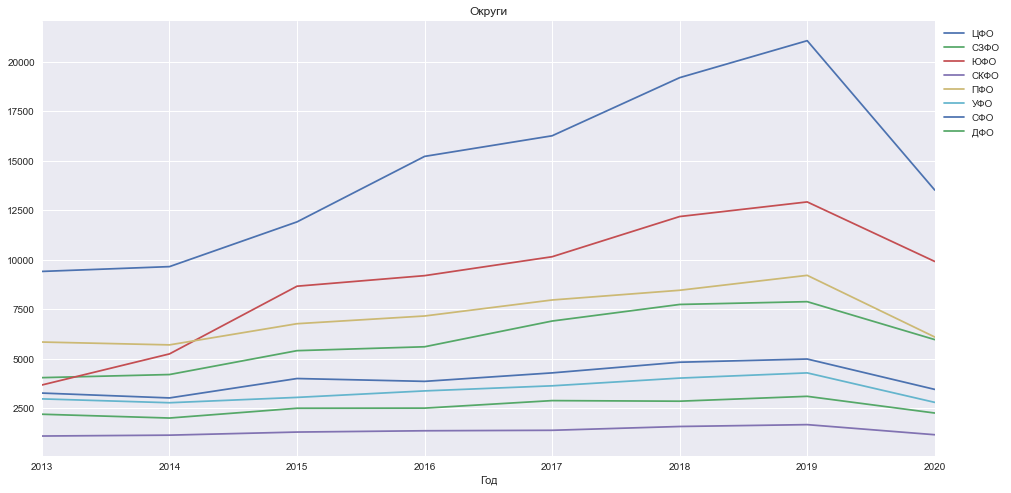

In [6]:
ax = hierarchy_df_y[hierarchy['total']].plot(title="Округи")
ax.legend(bbox_to_anchor=(1.0, 1.0));

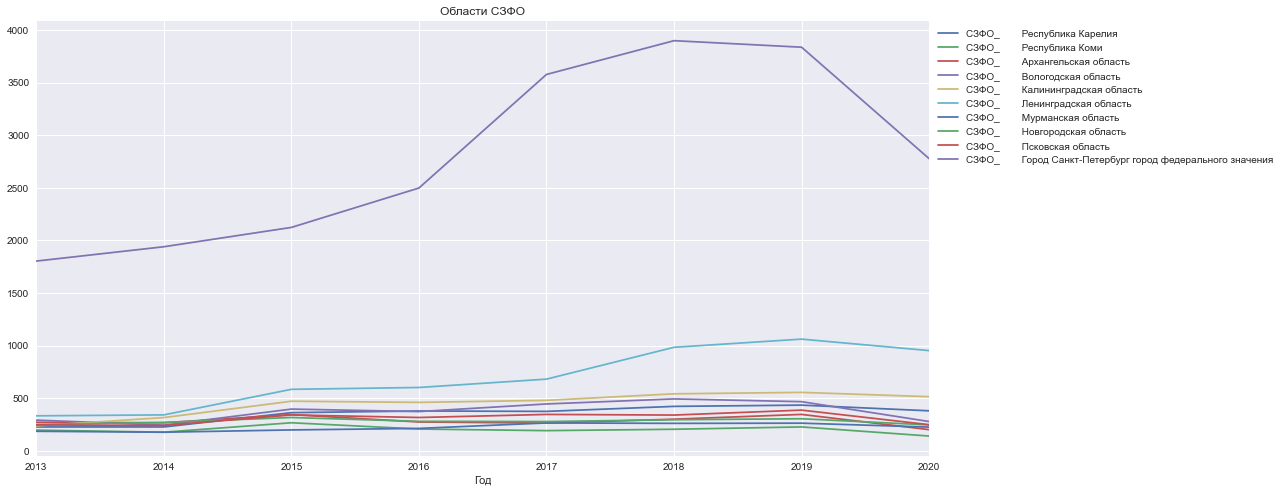

In [7]:
ax = hierarchy_df_y[hierarchy['СЗФО']].plot(title="Области CЗФО")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## ARIMA

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 191.16it/s]


MAE total: 6889.64
MAE СЗФО: 1988.28
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 352.54


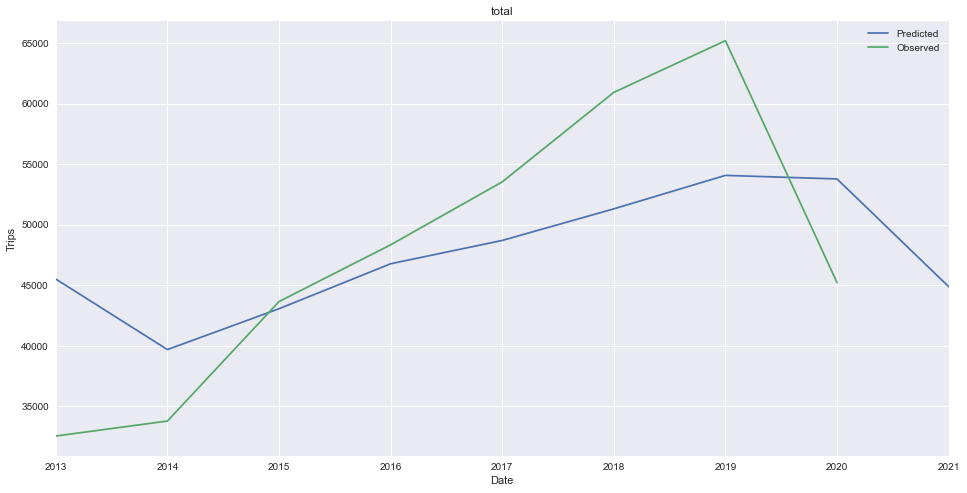

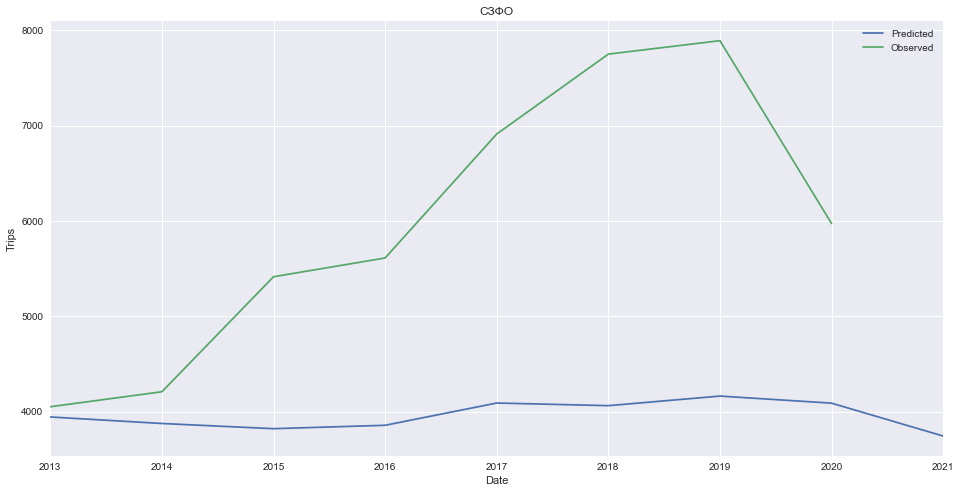

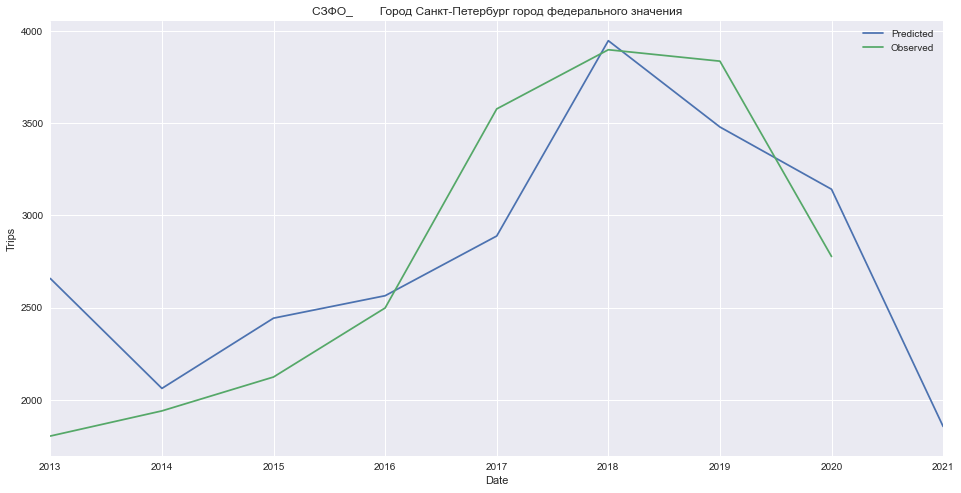

In [8]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 201.77it/s]


MAE total: 6766.26
MAE СЗФО: 1800.43
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 587.16


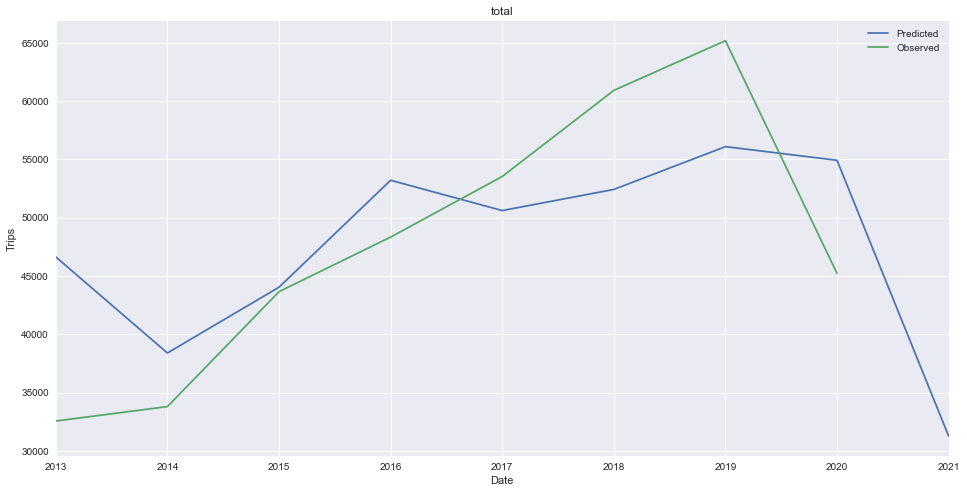

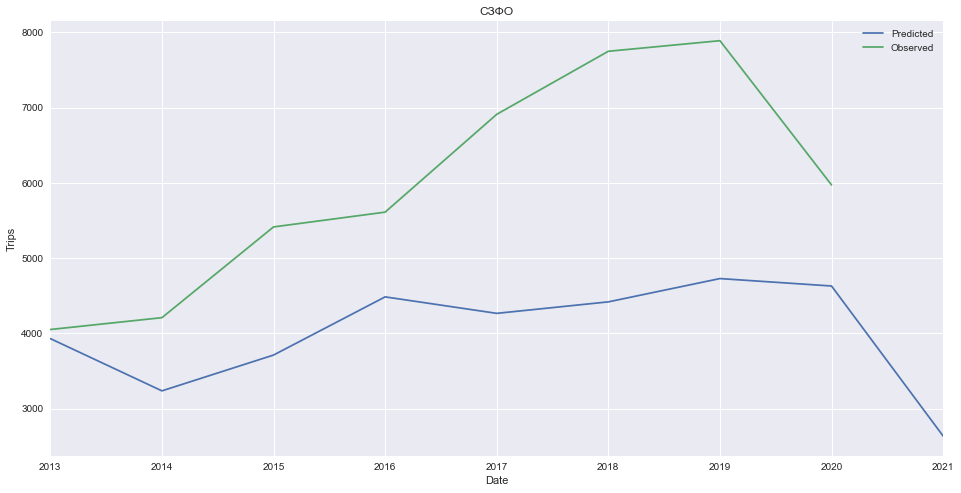

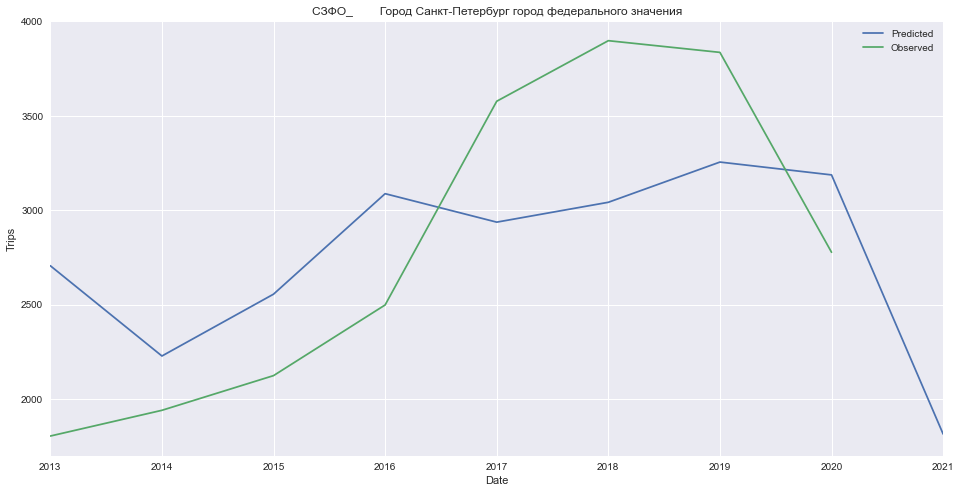

In [9]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach


Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 206.35it/s]


MAE total: 6768.92
MAE СЗФО: 693.53
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 355.29


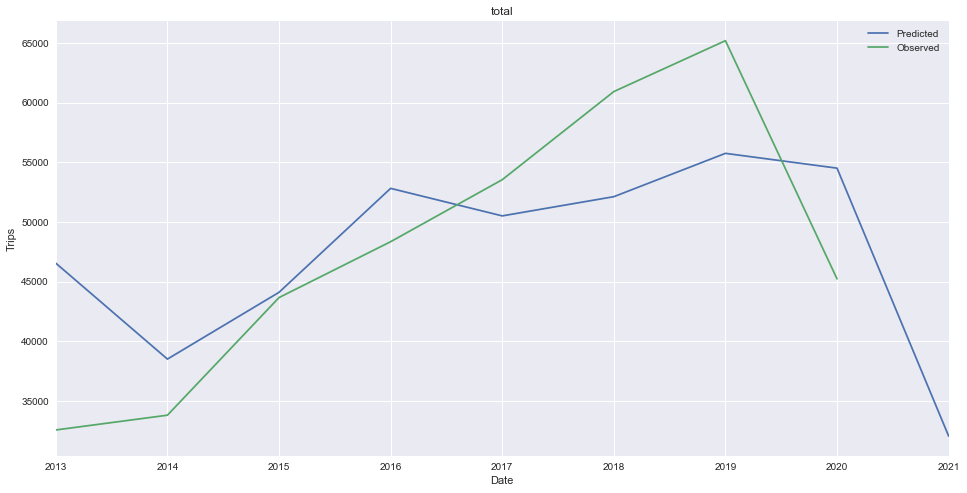

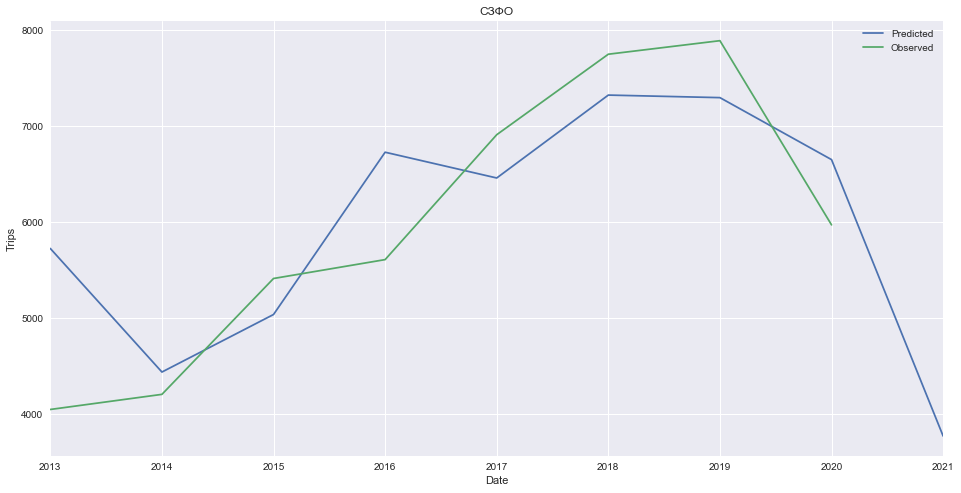

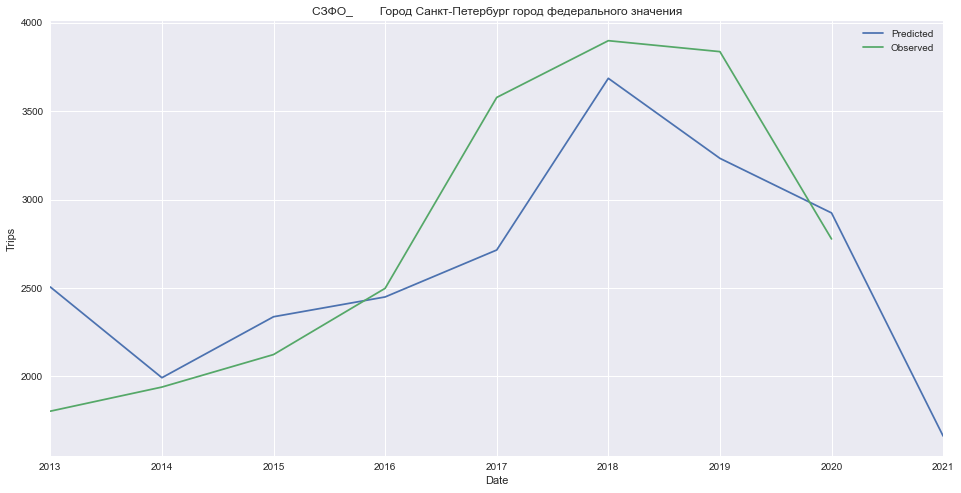

In [10]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'auto_arima', 'OLS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## Prophet

### Bottom-Up Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:54<00:00,  1.26s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026131529DF0>


MAE total: 5682.37
MAE СЗФО: 2008.23
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 294.21


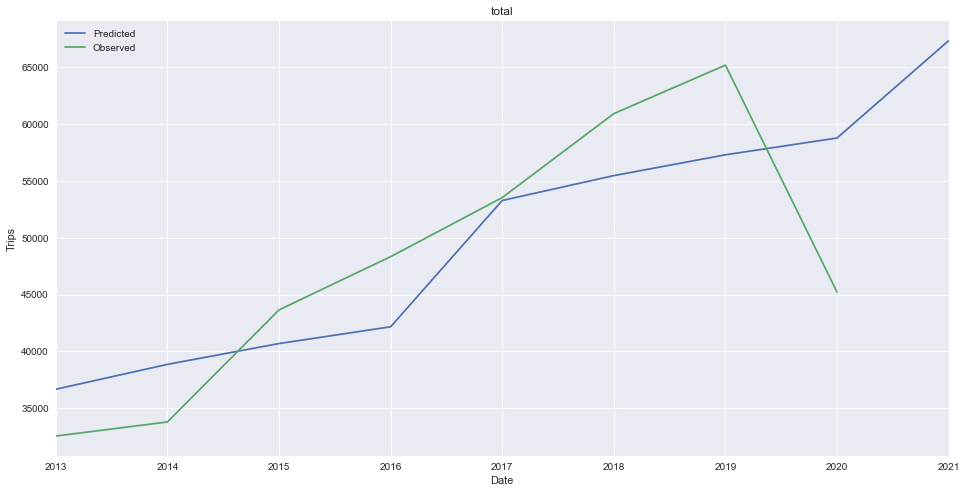

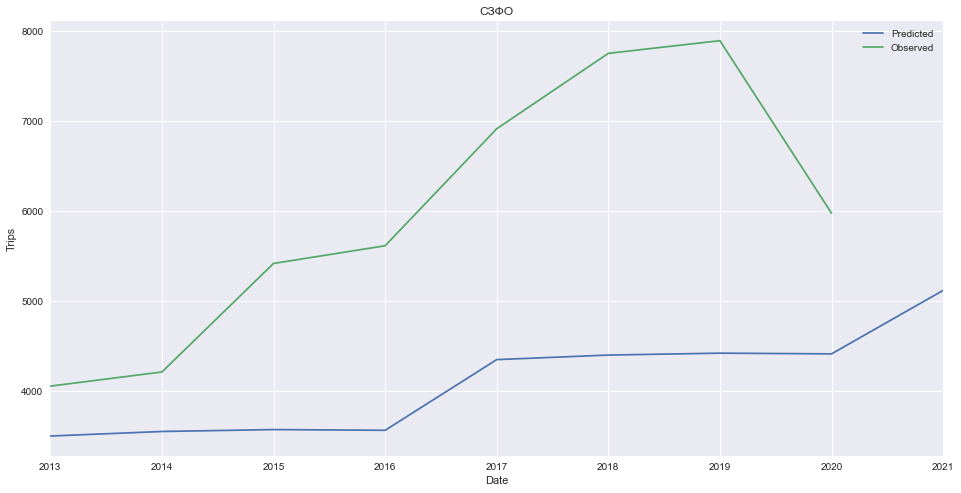

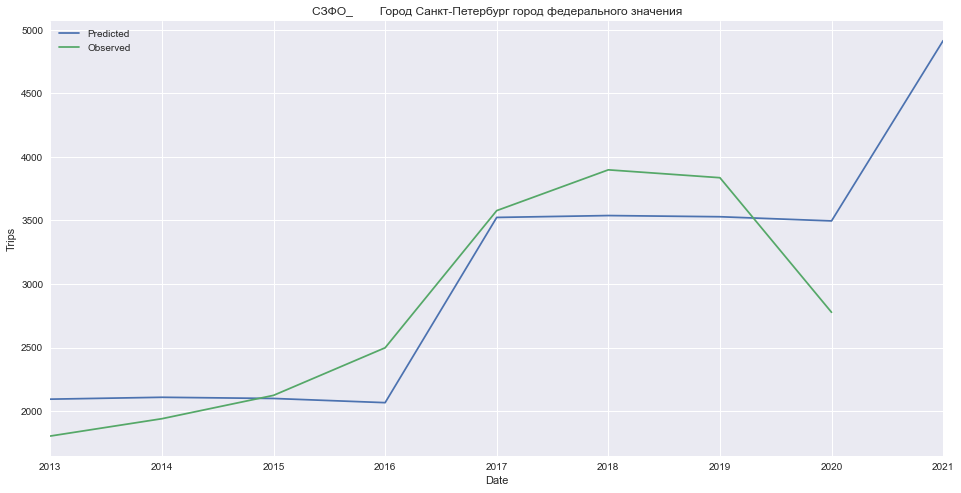

In [11]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:58<00:00,  1.30s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153D71D90>


MAE total: 5703.74
MAE СЗФО: 1940.75
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 406.73


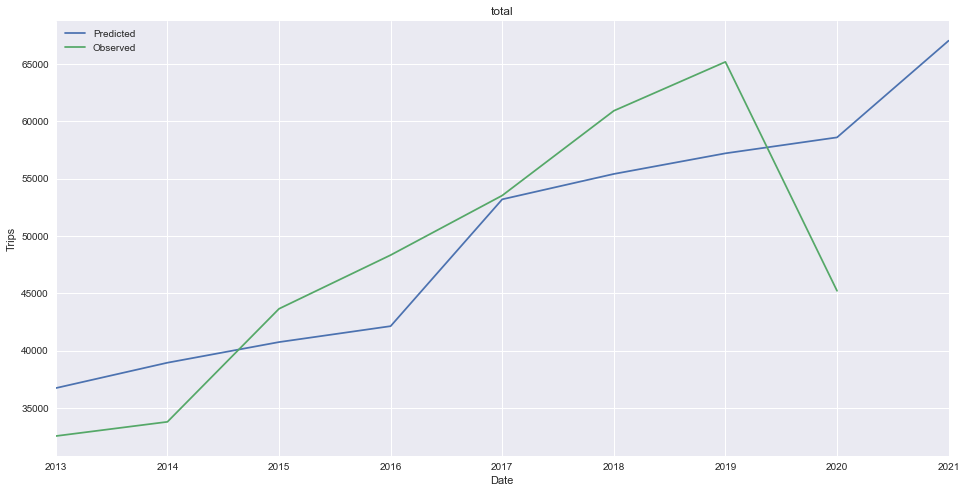

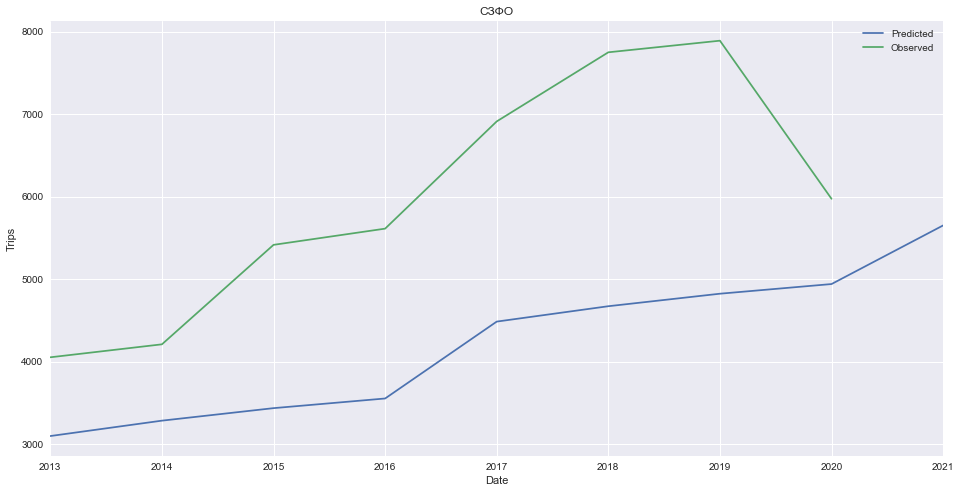

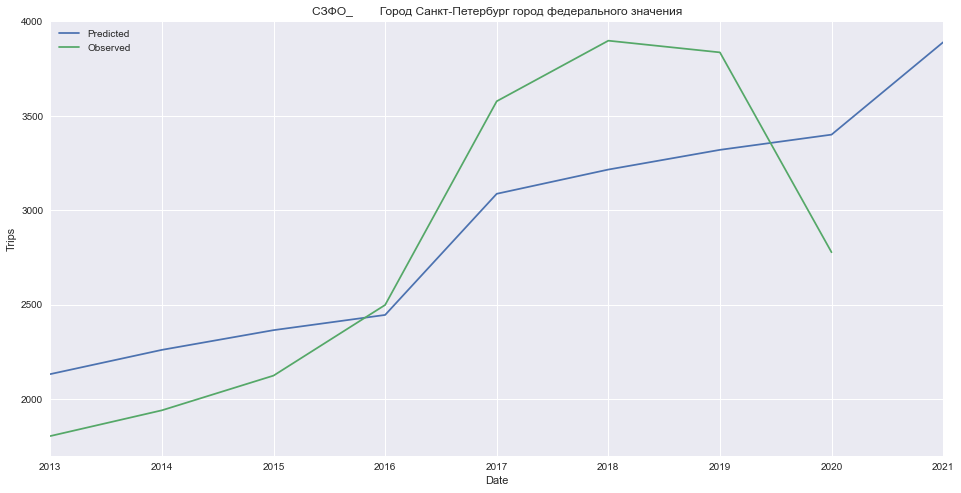

In [12]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:42<00:00,  1.13s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153C20BE0>


MAE total: 5748.68
MAE СЗФО: 632.81
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 354.17


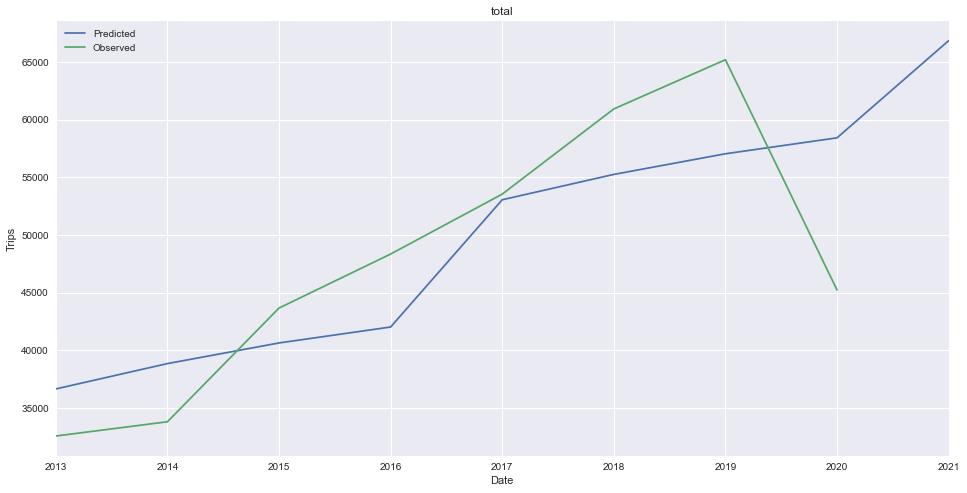

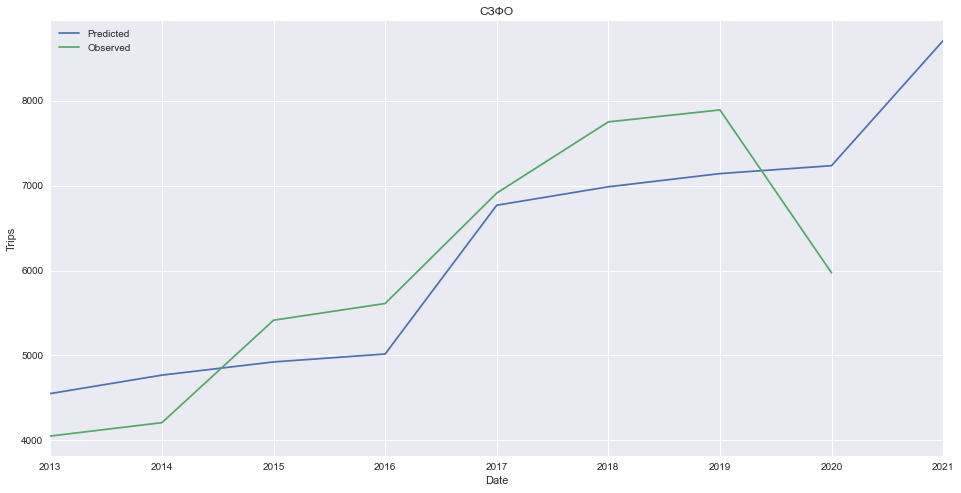

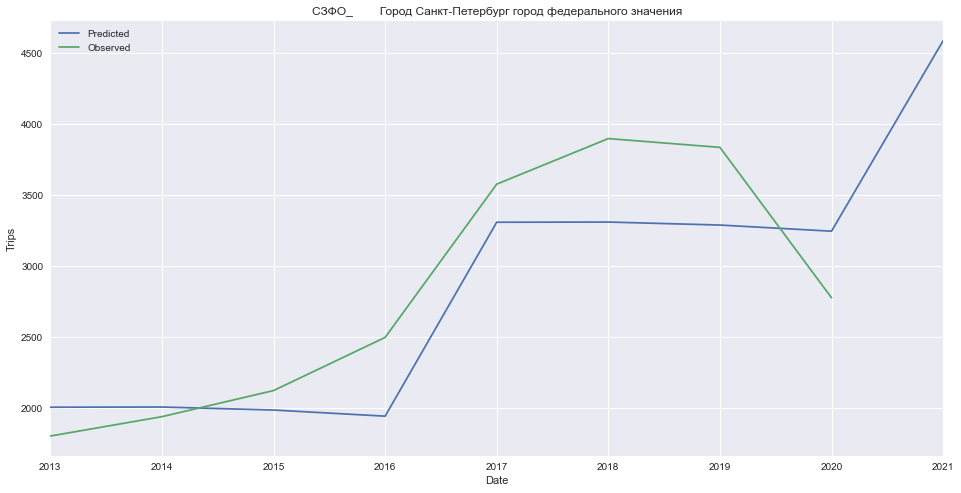

In [13]:
experiment(hierarchy_df_y, hierarchy, steps_ahead, 'prophet', 'OLS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

# Эксперименты с данными по кварталам

In [14]:
df_q = load_and_transform_df('data_q.csv')
hierarchy_df_q = create_hierarchy_df(df_q, is_q=True)

<AxesSubplot:title={'center':'total level'}, xlabel='Год'>

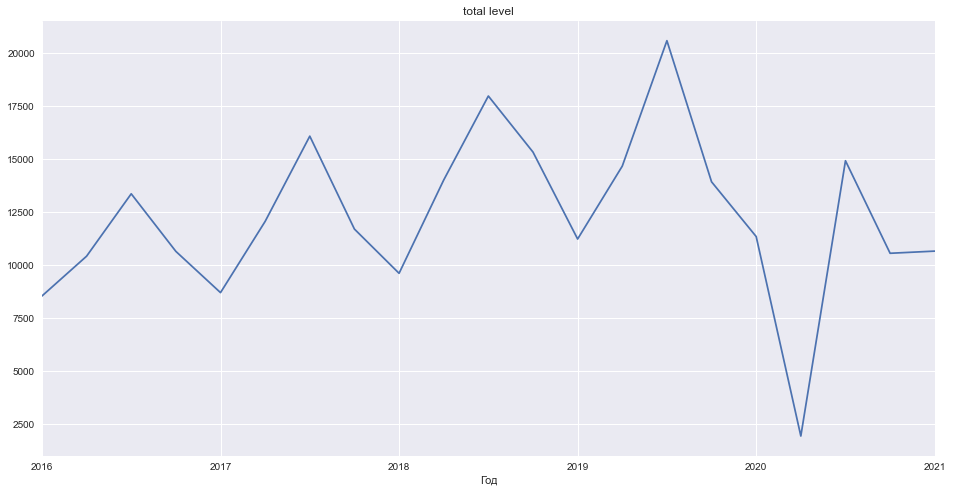

In [18]:
hierarchy_df_q["total"].plot(title="total level")

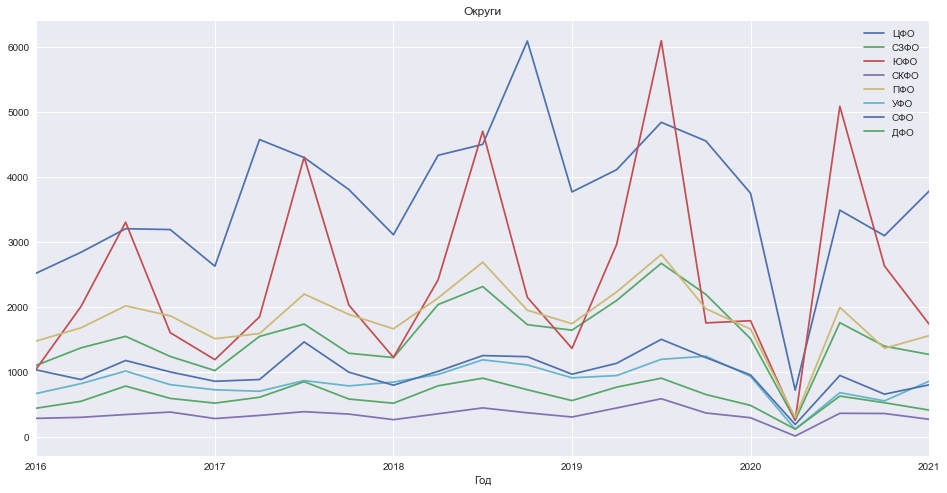

In [19]:
ax = hierarchy_df_q[hierarchy['total']].plot(title="Округи")
ax.legend(bbox_to_anchor=(1.0, 1.0));

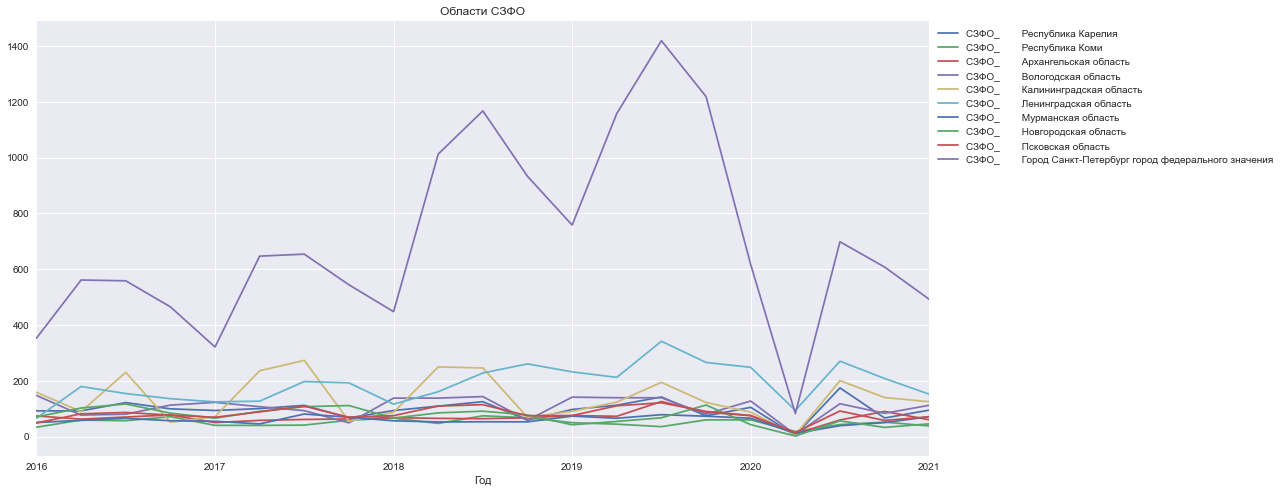

In [20]:
ax = hierarchy_df_q[hierarchy['СЗФО']].plot(title="Области CЗФО")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## ARIMA

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 232.15it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153E90F70>


MAE total: 2574.93
MAE СЗФО: 639.74
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 222.95


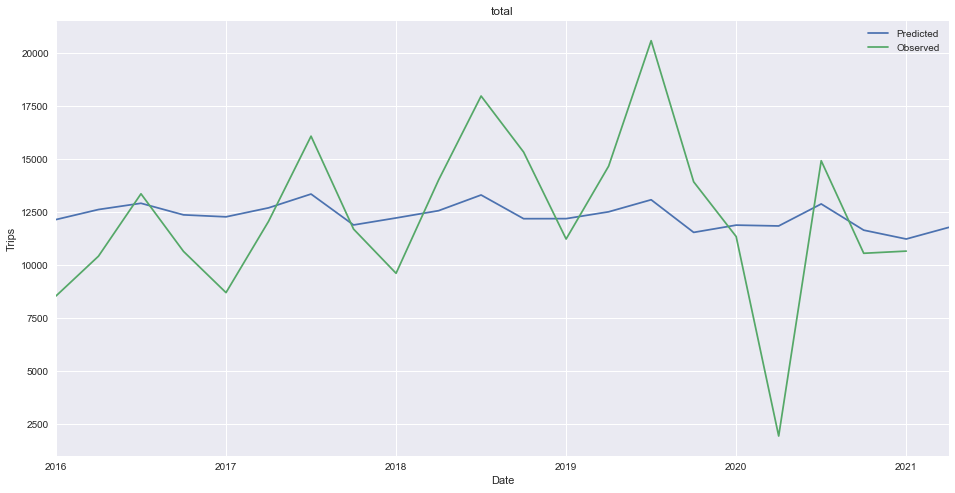

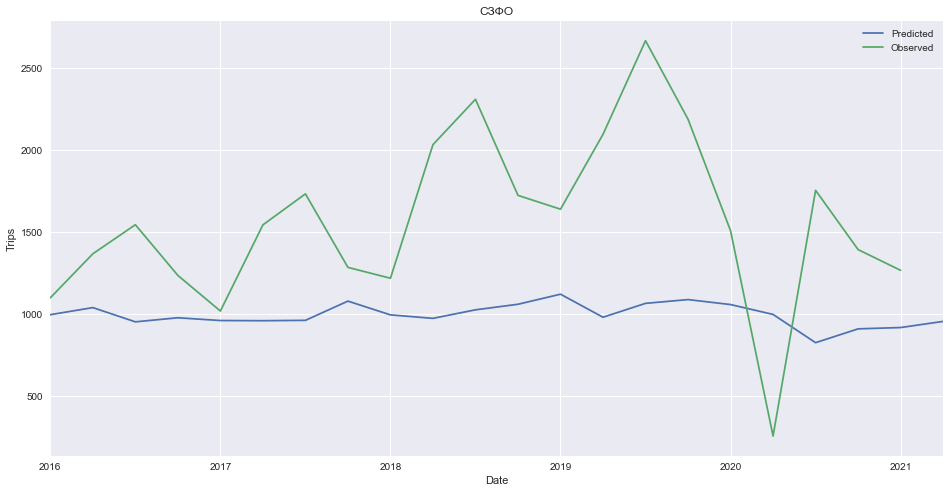

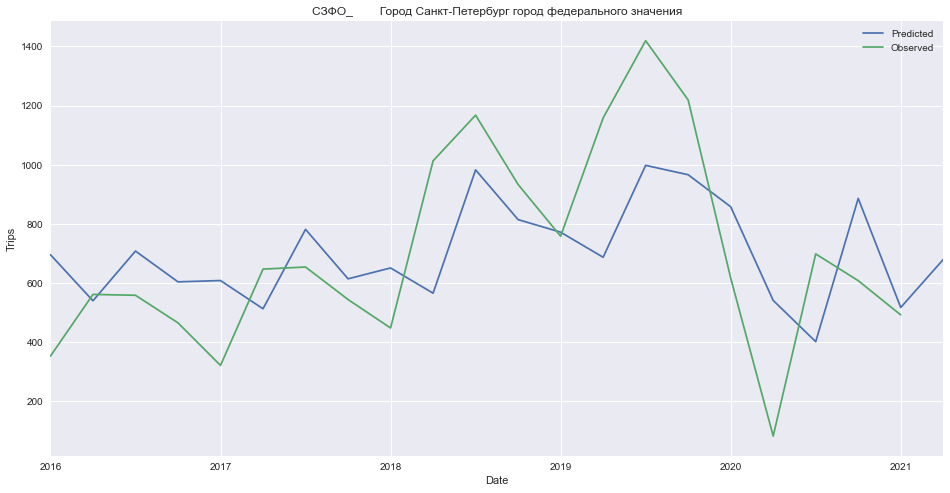

In [21]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 236.04it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002615618D430>


MAE total: 2870.74
MAE СЗФО: 619.37
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 256.7


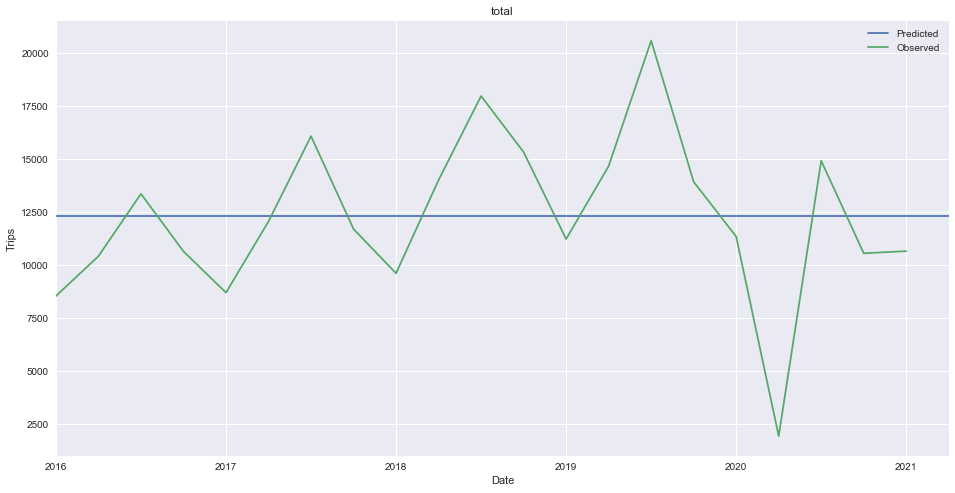

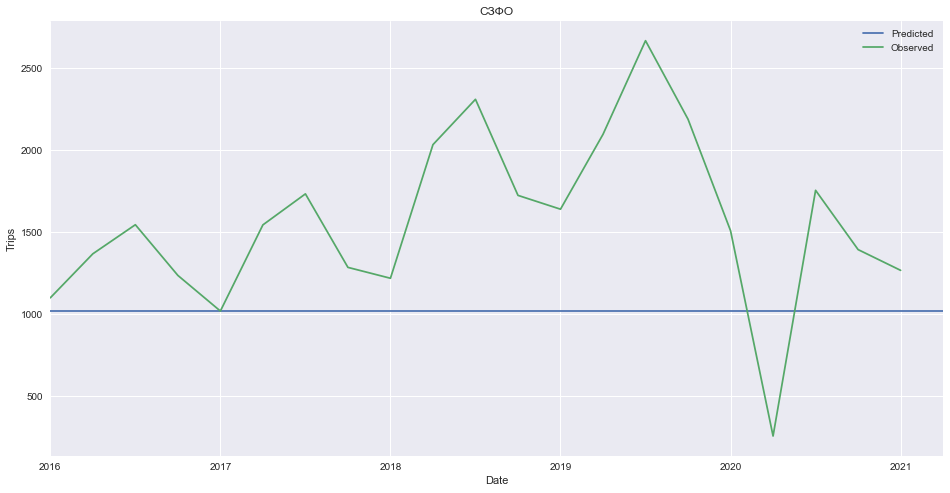

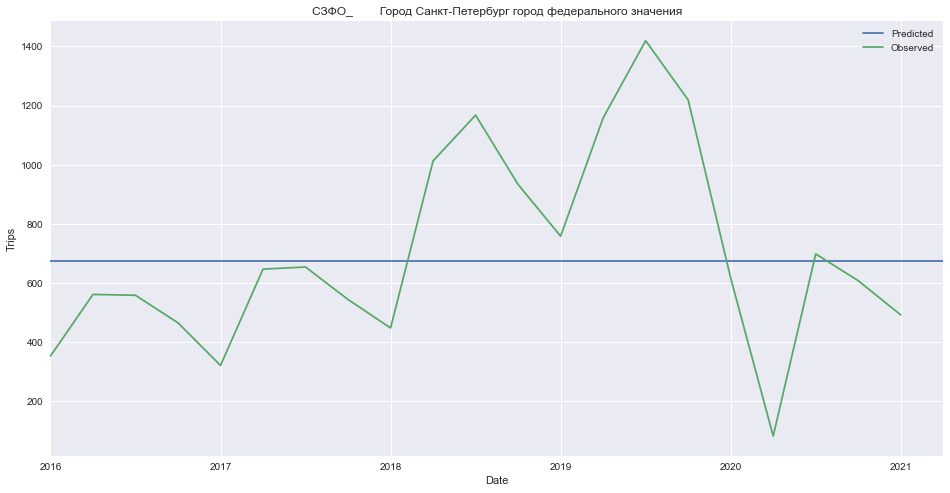

In [22]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 234.82it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153F85340>


MAE total: 2818.19
MAE СЗФО: 392.02
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 222.51


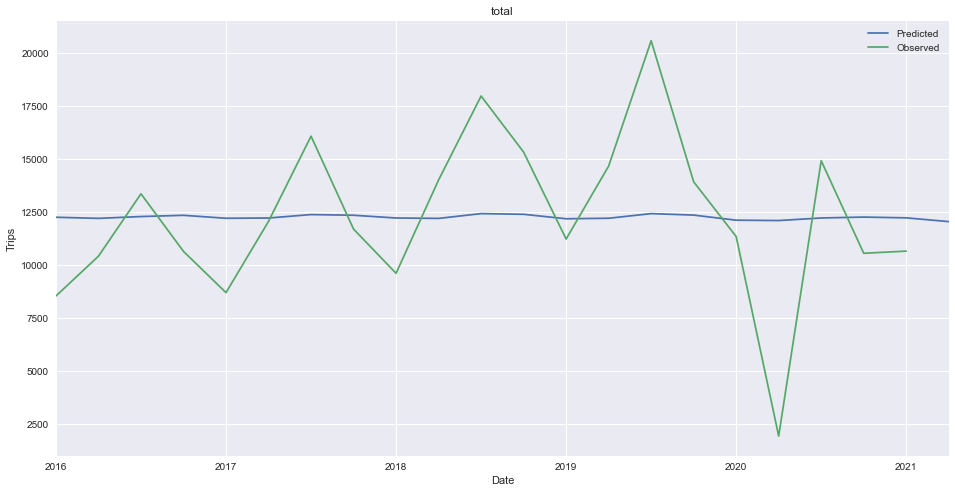

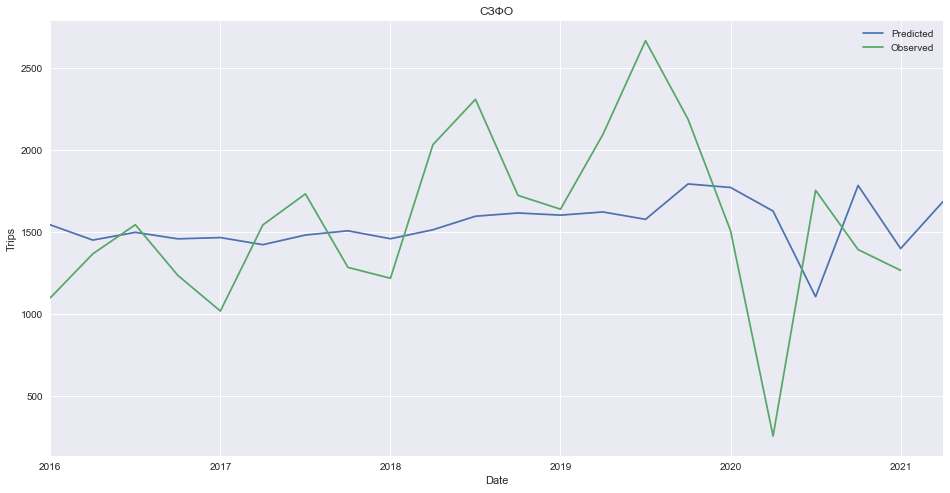

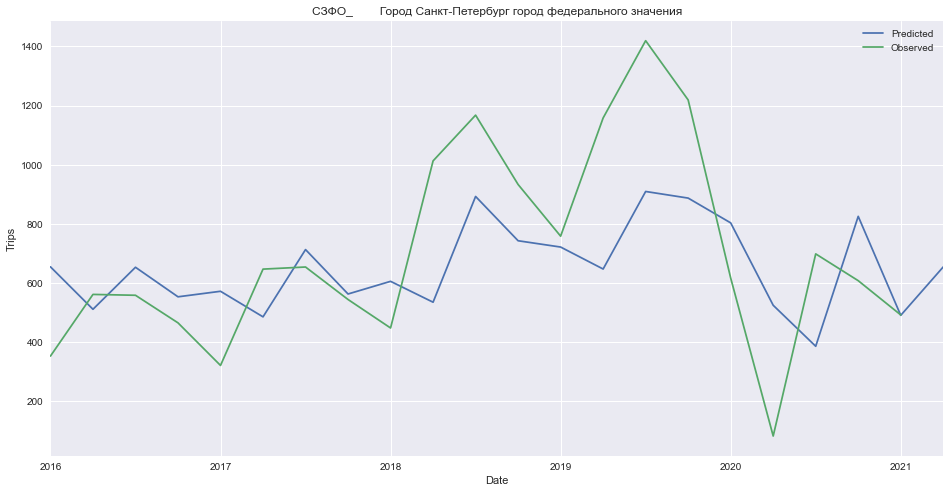

In [23]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'auto_arima', 'OLS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## SARIMAX

### Bottom-Up Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 380.77it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153F95AF0>


MAE total: 4009.95
MAE СЗФО: 773.82
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 234.69


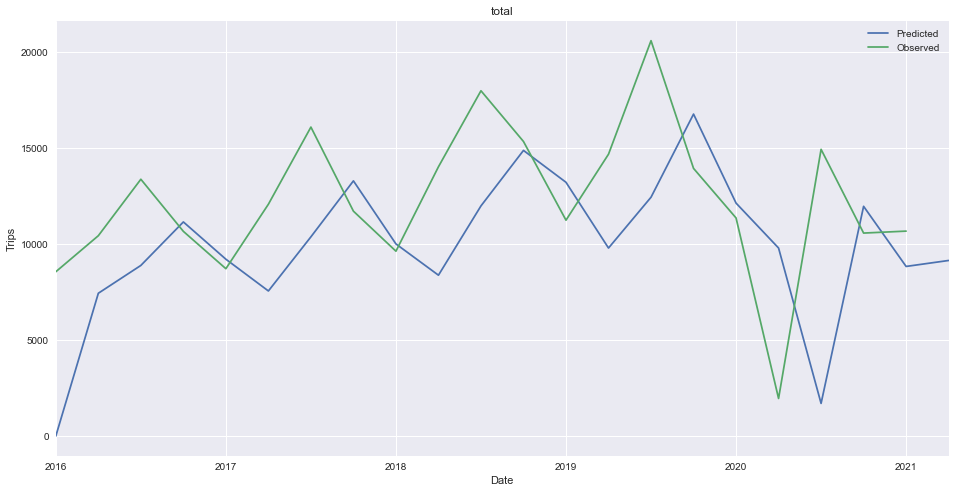

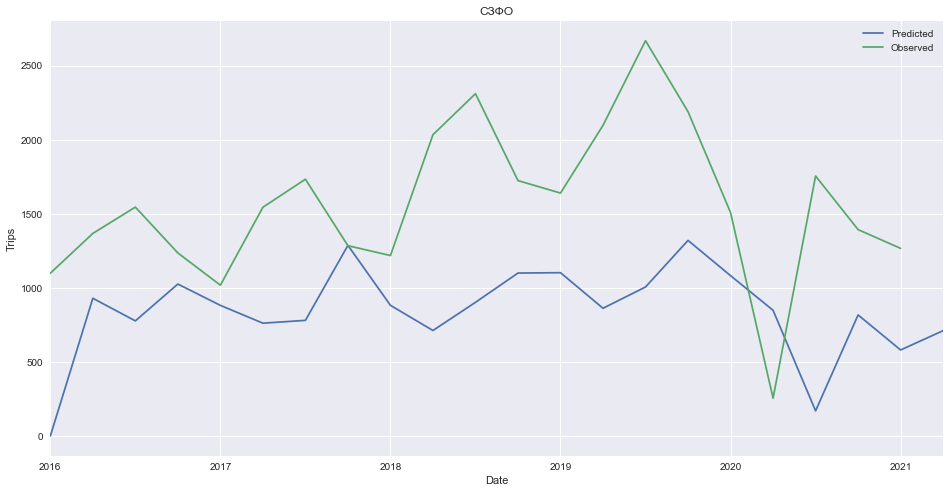

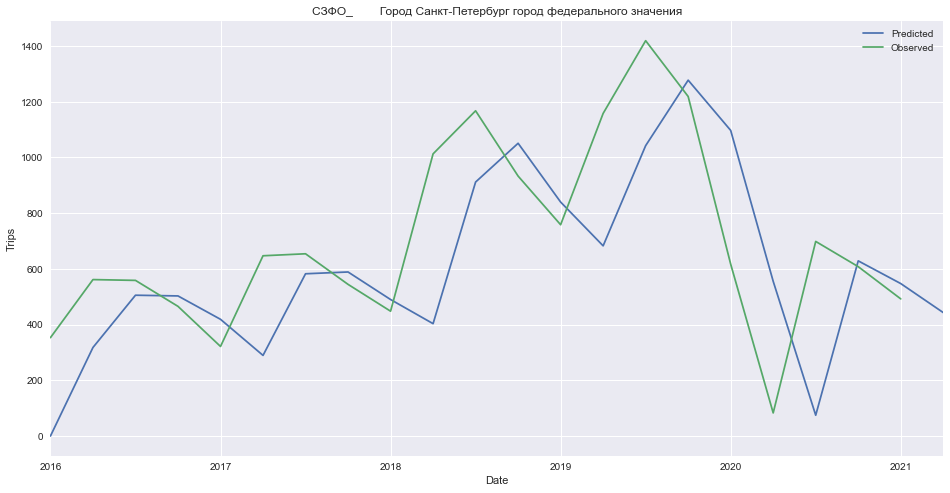

In [24]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 327.34it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002615803B640>


MAE total: 4211.98
MAE СЗФО: 732.45
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 259.49


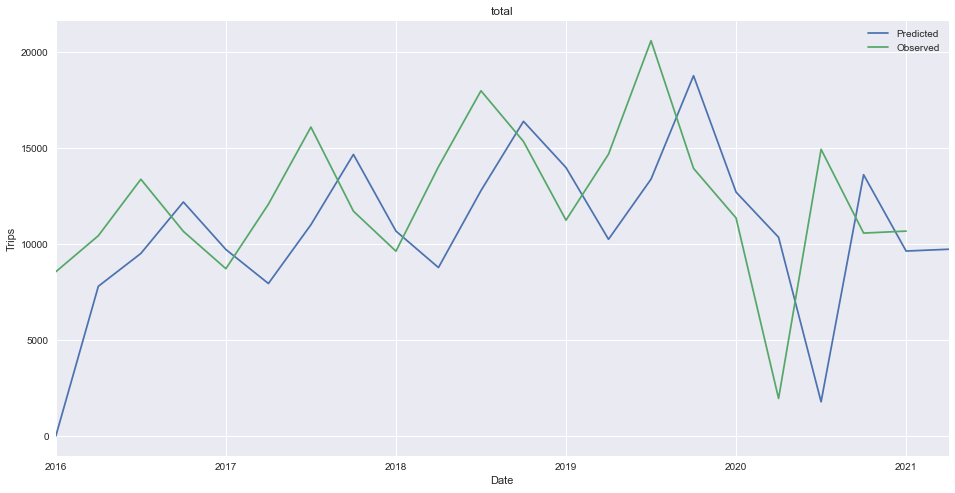

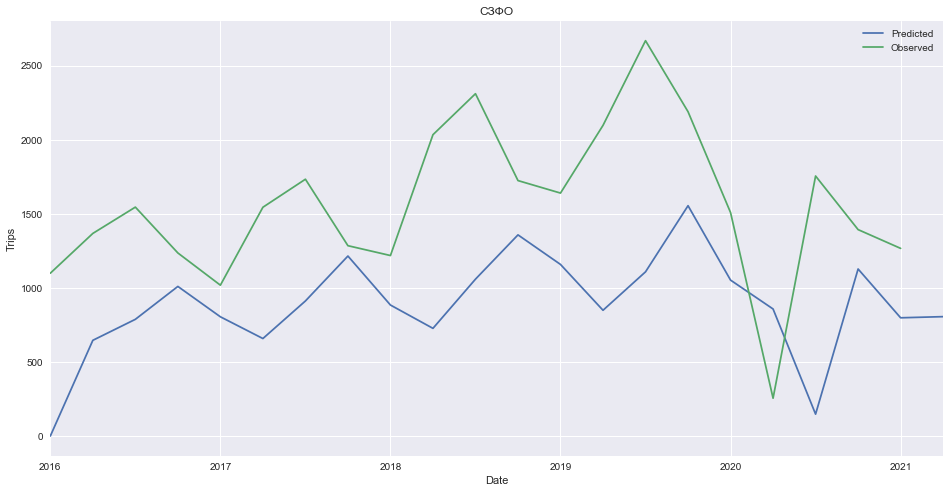

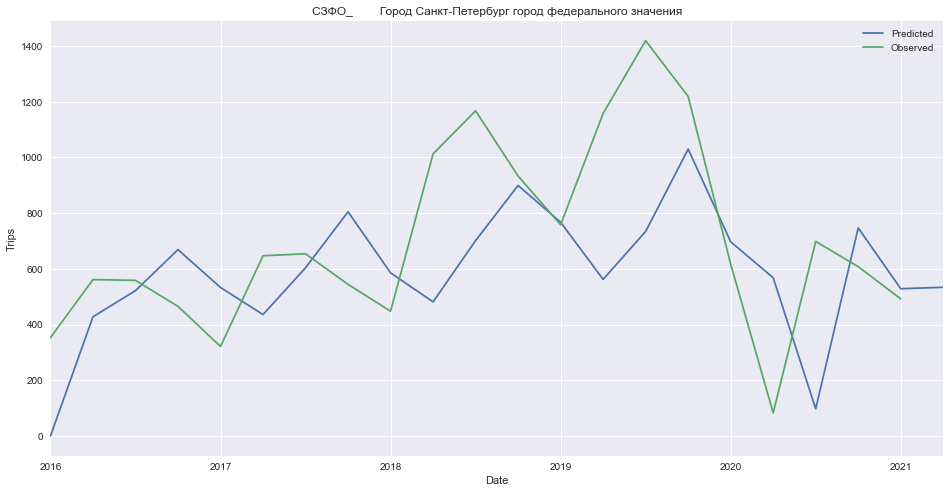

In [25]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 306.40it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026157A03D00>


MAE total: 4186.66
MAE СЗФО: 497.12
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 232.62


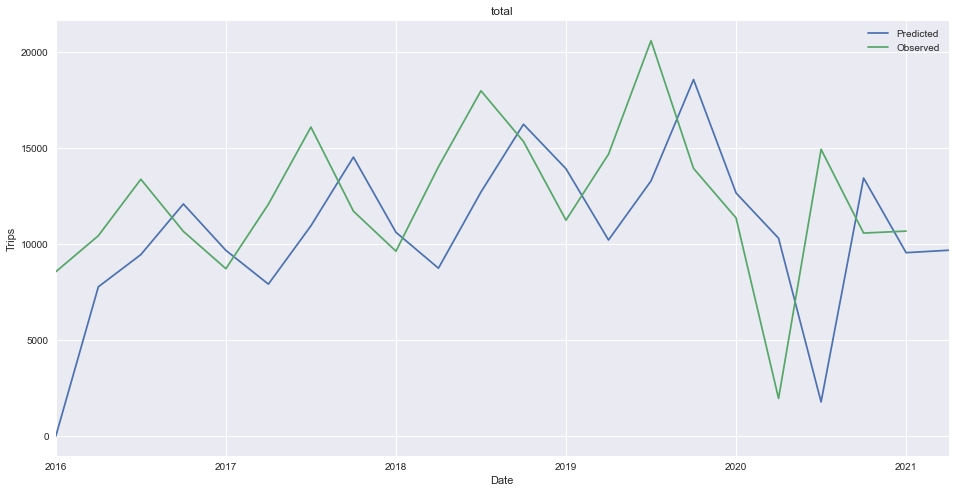

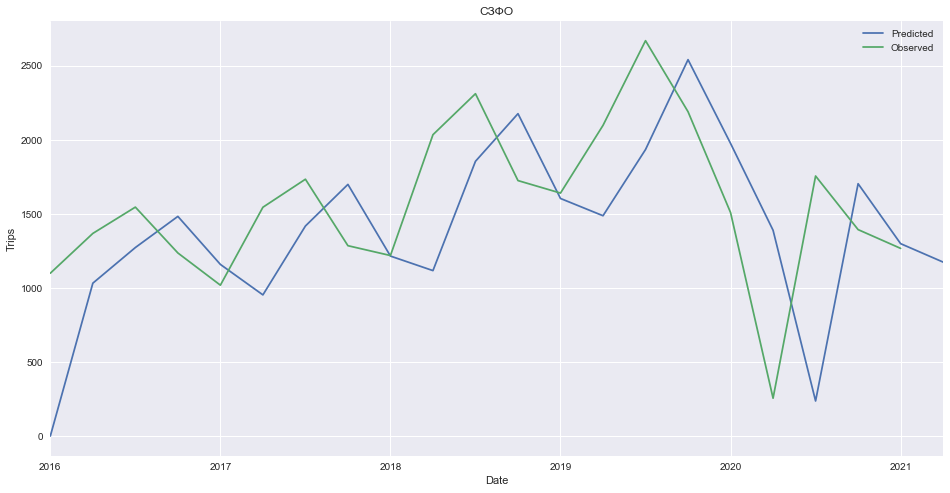

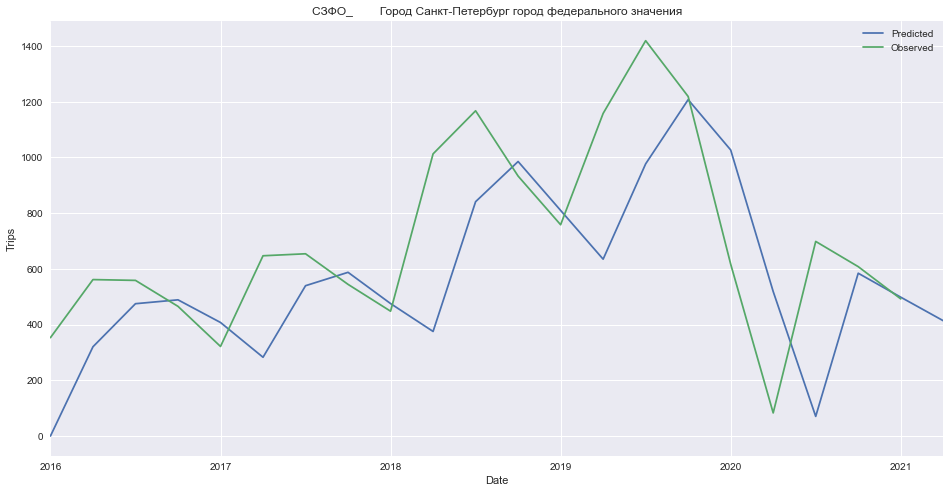

In [26]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'sarimax', 'OLS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

## Prophet

### Bottom-Up Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [02:00<00:00,  1.32s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026156115E80>


MAE total: 1252.55
MAE СЗФО: 589.25
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 89.03


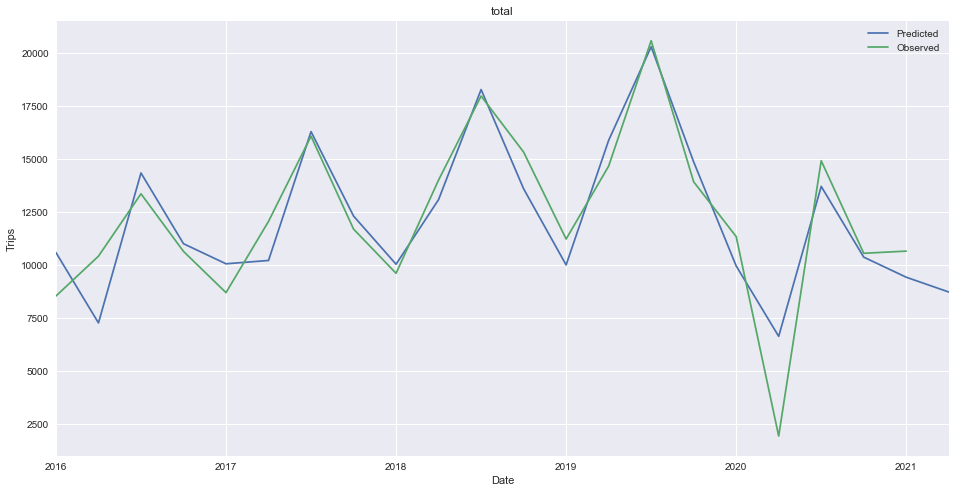

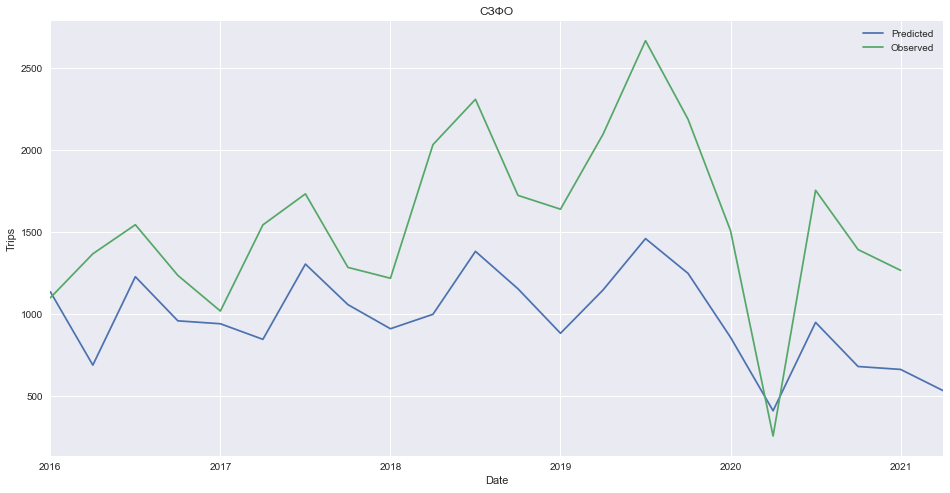

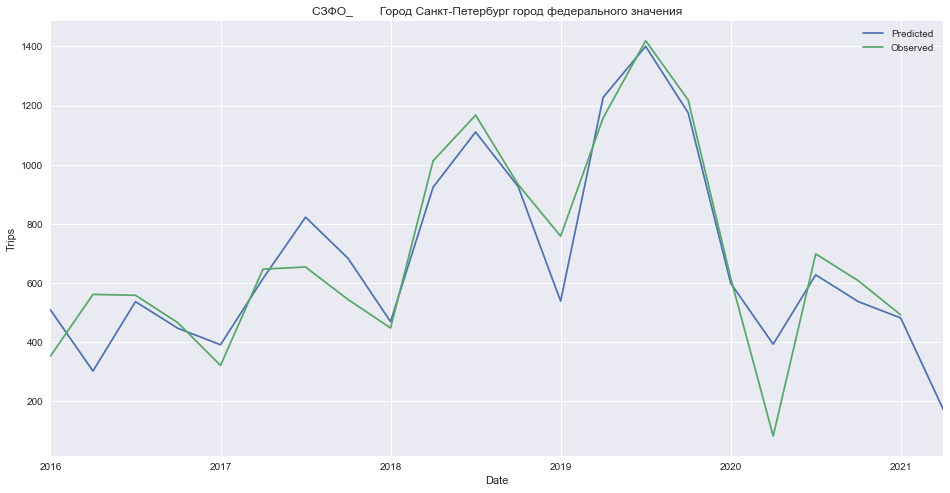

In [15]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'BU', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Top-Down Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:55<00:00,  1.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153FE7760>


MAE total: 1237.69
MAE СЗФО: 574.4
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 184.05


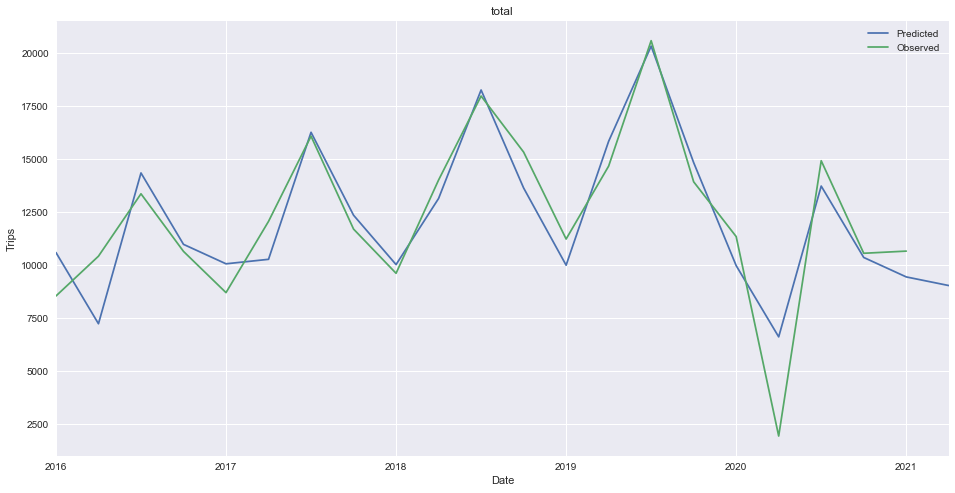

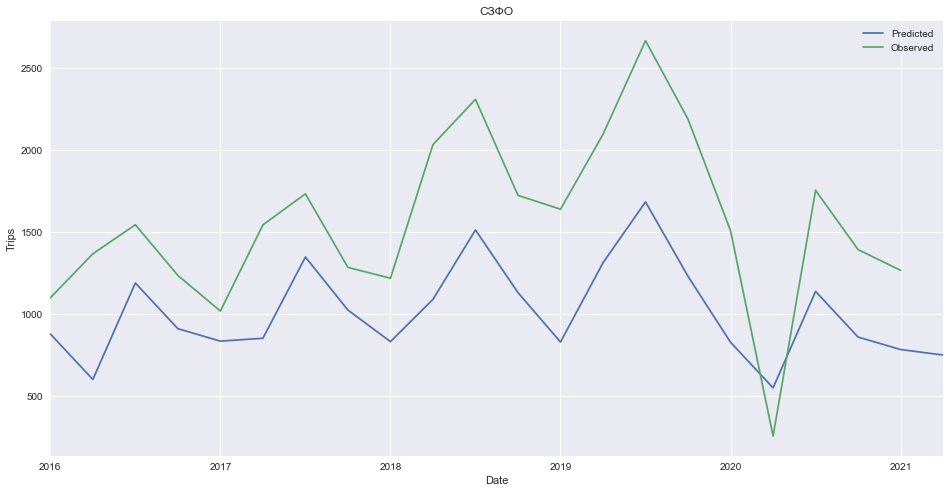

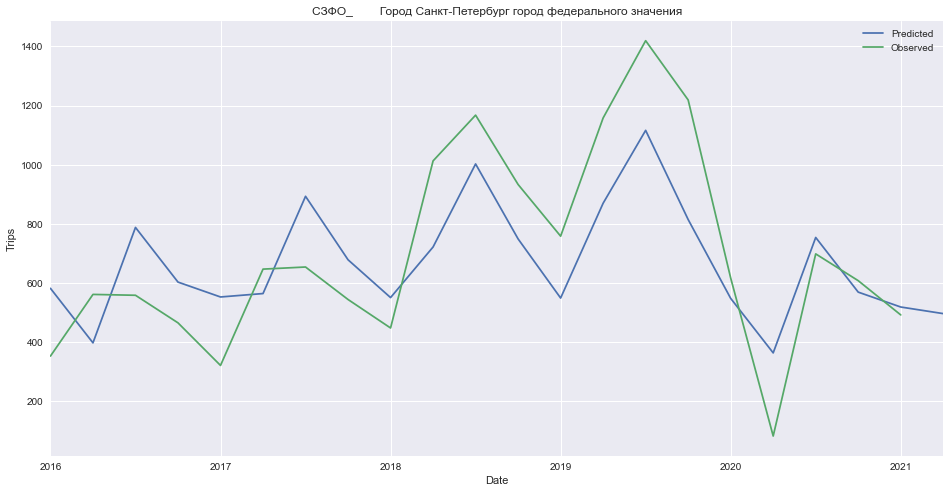

In [16]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'AHP', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])

### Optimal Reconciliation Approach

Fitting models: 100%|██████████████████████████████████████████████████████████████████| 91/91 [01:50<00:00,  1.21s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000026153919460>


MAE total: 1235.88
MAE СЗФО: 179.19
MAE СЗФО_        Город Санкт-Петербург город федерального значения: 112.45


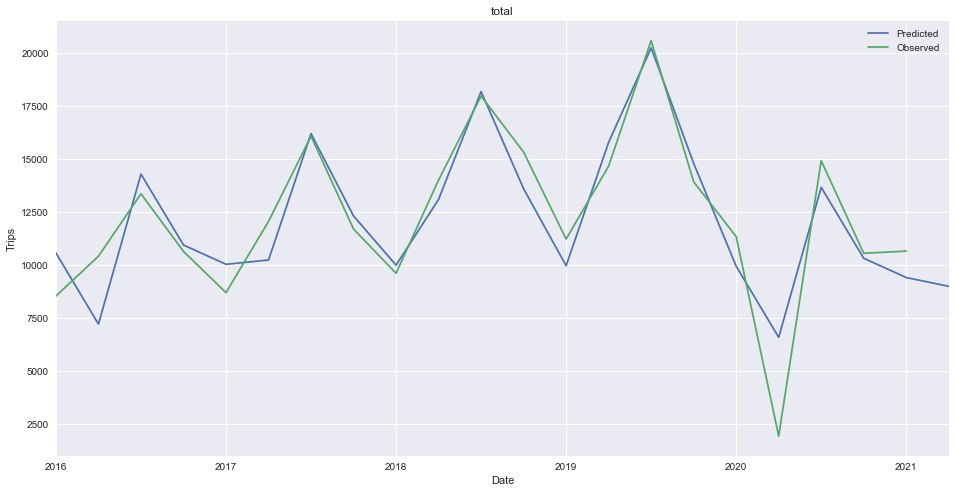

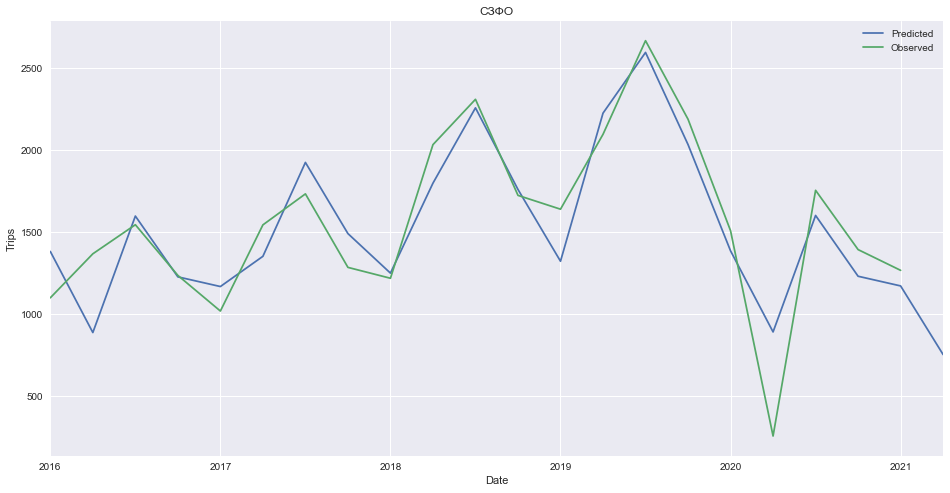

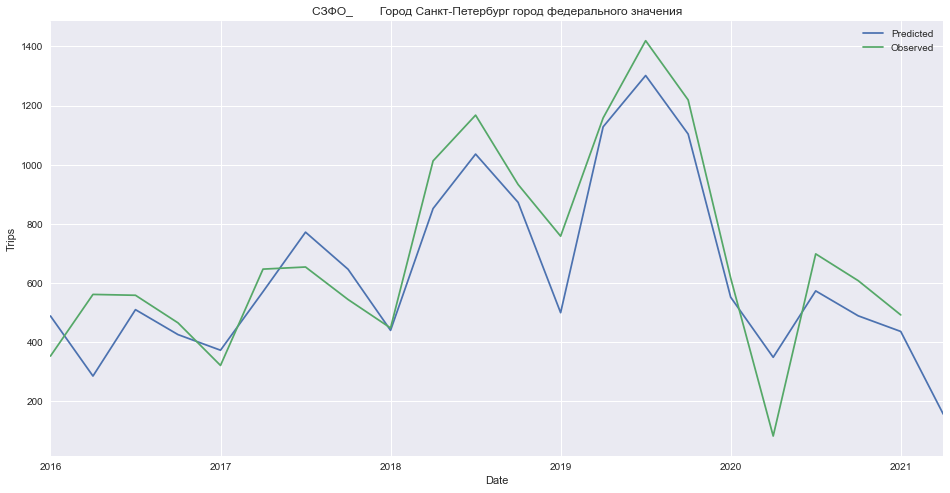

In [17]:
experiment(hierarchy_df_q, hierarchy, steps_ahead, 'prophet', 'OLS', [['total'],['СЗФО'], ['СЗФО_        Город Санкт-Петербург город федерального значения']])